In [1]:
%load_ext autoreload
%autoreload 2

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomTreesEmbedding

from lightgbm import LGBMClassifier

from umap import UMAP

from hml.ensemble import GraphArchetypeEncoder, GraphArchetypeUMAP, ClusterArchetypeEncoder, ClusterArchetypeUMAP, ForestTransformer, TargetArchetypeEncoder
from hml.meta_estimators import ArchetypeEnsembleClassifier


# Load Spaceship Titanic Dataset

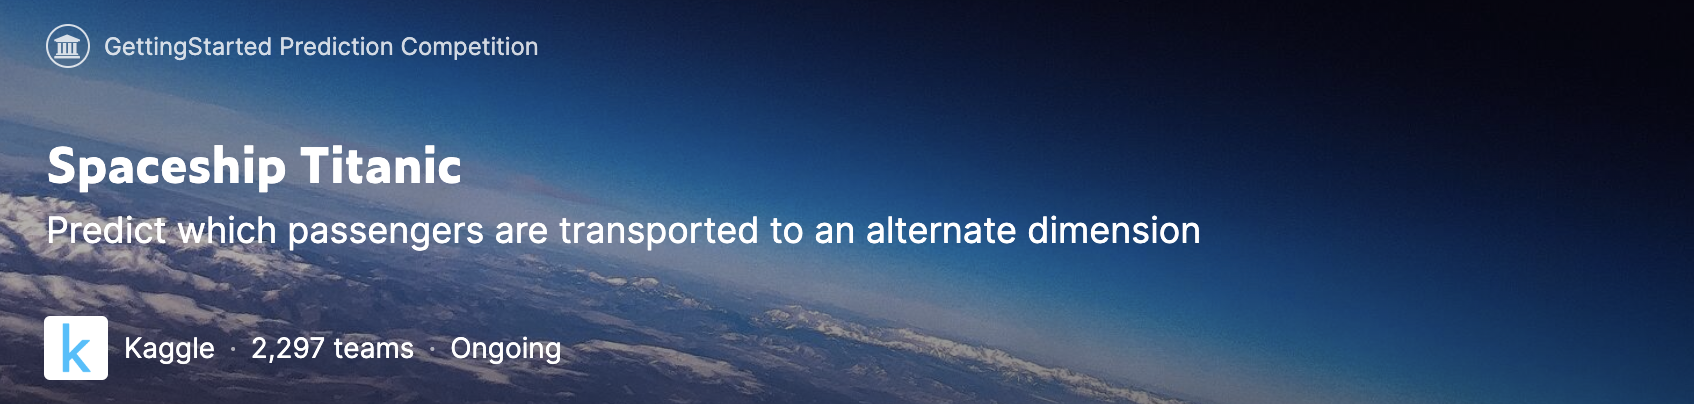


## Dataset Description

> In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## File and Data Field Descriptions
- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    - PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    - HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    - CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    - Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    - Destination - The planet the passenger will be debarking to.
    - Age - The age of the passenger.
    - VIP - Whether the passenger has paid for special VIP service during the voyage.
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    - Name - The first and last names of the passenger.
    - Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
df = pd.read_csv("./examples/train.csv") 

#  Feature Engineering

In [5]:
def feature_eng(df):
    
    df = df.copy()    
    
    df["Cabin0"] = df["Cabin"].str.split("/").str[0]
    df["Cabin1"] = df["Cabin"].str.split("/").str[1].astype(float)
    df["Cabin2"] = df["Cabin"].str.split("/").str[2]
            
    df["GroupSize"] = df.groupby(df.PassengerId.str.split("_").str[0])["PassengerId"].transform(lambda x: len(x))
    df["CabinCount"] = df.groupby("Cabin")["Cabin"].transform(lambda x: len(x))
    
    #Dummy feature
    df["NameLength"] = df["Name"].str.len()
    df["IdRank"] = df["PassengerId"].str.split("_").str[1].astype(float)
    
    return df


In [8]:
df = feature_eng(df)

In [9]:
train_df, test_df = train_test_split(df, test_size = 0.2)

# Feature Names

In [10]:
TARGET = "Transported"

In [12]:
NUM_FEATURES = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Cabin1', 'GroupSize', 'CabinCount', 'NameLength']

CAT_FEATURES = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin0', 'Cabin2']

# Preprocessing Pipeline

In [14]:

prep_pipeline = ColumnTransformer(
    [
        (
            "categorical_pipe",
            make_pipeline(
                FunctionTransformer(lambda x: x.astype(str)),
                OneHotEncoder()
            ),
            CAT_FEATURES
        ),
        (
            "numerical_pipe",
            SimpleImputer(strategy="median", add_indicator=True),
            NUM_FEATURES
        ),
    ]
)


In [15]:
prep_pipeline.fit(train_df)

ColumnTransformer(transformers=[('cat_pipe',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function <lambda> at 0x17f33ba30>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'Cabin0', 'Cabin2']),
                                ('num_pipe',
                                 SimpleImputer(add_indicator=True,
                                               strategy='median'),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck', 'Cabin1',
                                  'GroupSize', 'CabinCount', 'NameLength'])])

In [16]:
X_train = prep_pipeline.transform(train_df)
X_test = prep_pipeline.transform(test_df)

In [17]:
y_train, y_test = train_df[TARGET], test_df[TARGET]

# Embeddigs of leaf space
> Tree leaf space is a rich representation of the data. the interesting fact is that it is easy to represent joint distributions of heterogeneous data sets due the nature of tree ensembles. Also, one could leverage the supervision signal of tree ensembles to scale the joint distribution, that is, give more importance when the variance comes from an important feature in the prediction task.

## Induce ensemble

In [427]:
forest_ensemble = RandomForestClassifier()
#forest_ensemble = RandomTreesEmbedding()

In [428]:
forest_ensemble.fit(X_train, y_train)

RandomForestClassifier()

In [429]:
forest_ensemble.apply(X_train), forest_ensemble.apply(X_train).shape

(array([[1041, 1921, 2529, ..., 2144, 1915, 2639],
        [ 991,  390, 2380, ..., 1947, 1048,  755],
        [1263,    8, 2360, ...,  773, 1340,  127],
        ...,
        [1623,  998,  236, ...,  914,   67, 1183],
        [ 581,  107, 1845, ..., 2618, 1252,  687],
        [1693, 2893, 1413, ..., 1779, 2788, 1009]]),
 (6954, 100))

## REduce dimensionality of leaf space

In [430]:
umap = UMAP(metric = "hamming").fit(forest_ensemble.apply(X_train))
test_df.loc[:, ["umap0","umap1"]] = umap.transform( forest_ensemble.apply(X_test))

In [431]:
CAT_FEATURES

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin0', 'Cabin2']

In [434]:
test_df["model_score"] = forest_ensemble.predict_proba(X_test)[:,1]

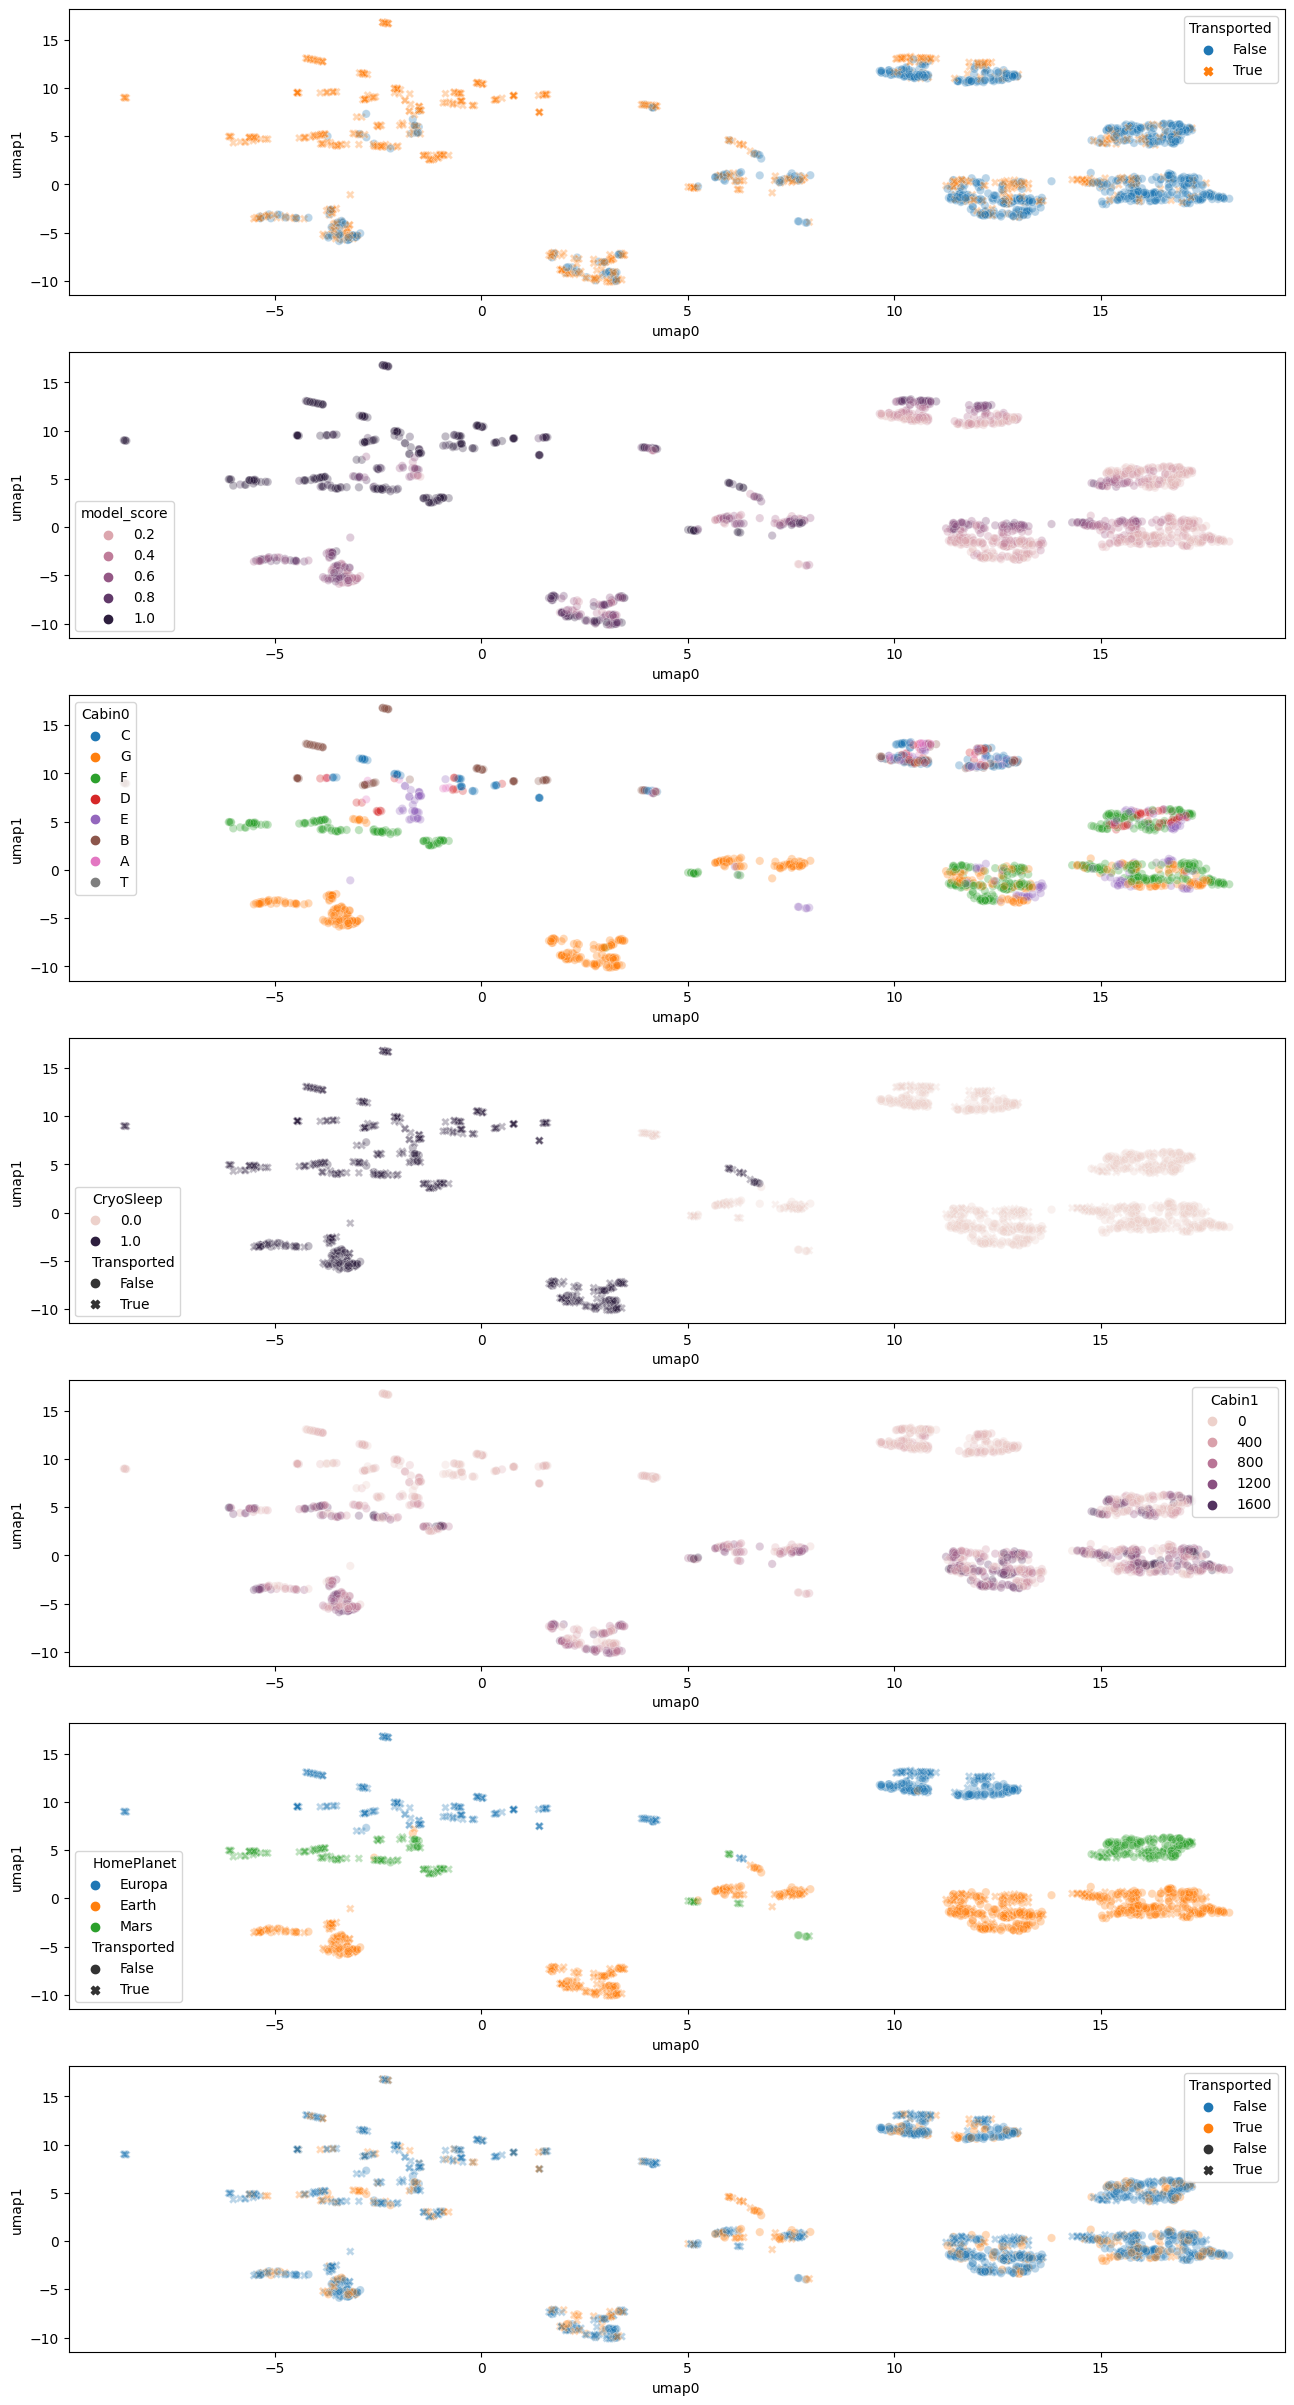

In [435]:
fig, axs = plt.subplots(7)

sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = TARGET, alpha = 0.3, style = TARGET, ax = axs[0])
sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = "model_score", alpha = 0.3, ax = axs[1])
sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = "Cabin0", alpha = 0.3, ax = axs[2])
sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = "CryoSleep", alpha = 0.3, style = TARGET, ax = axs[3])
sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = "Cabin1", alpha = 0.3, ax = axs[4])
sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = "HomePlanet", alpha = 0.3, style = TARGET, ax = axs[5])
sns.scatterplot(data = test_df, x="umap0", y="umap1", hue = test_df.isna().any(1), alpha = 0.3, style = TARGET, ax = axs[6])

plt.subplots_adjust(-1,-4)

# Leveraging ensembles using ensemble leaf space

## Regular estimator

In [26]:
#regular_ensemble = RandomForestClassifier(100, min_samples_leaf=4, n_jobs = -1)
regular_ensemble = LGBMClassifier()

#forest_embedder = make_pipeline(ForestTransformer  (TargetArchetypeEncoderest_ensemble), UMAP(n_jobs = -1, n_neighbors = 30))

In [27]:
regular_ensemble.fit(X_train, y_train)

LGBMClassifier()

In [28]:
test_df["naive_pred"] = regular_ensemble.predict_proba(X_test)[:,1]

## Forest Ensemble Enhanced Forest Ensemble
> This poor named meta ensemble: 
- first partitions the feature space based on clusters in leaf space (`ClusterArchetypeEncoder`)
- Second fits one model for each cluster and during inference, wieghts the output of each model according to datapoint membership for each cluster (`ArchetypeEnsembleClassifier`)

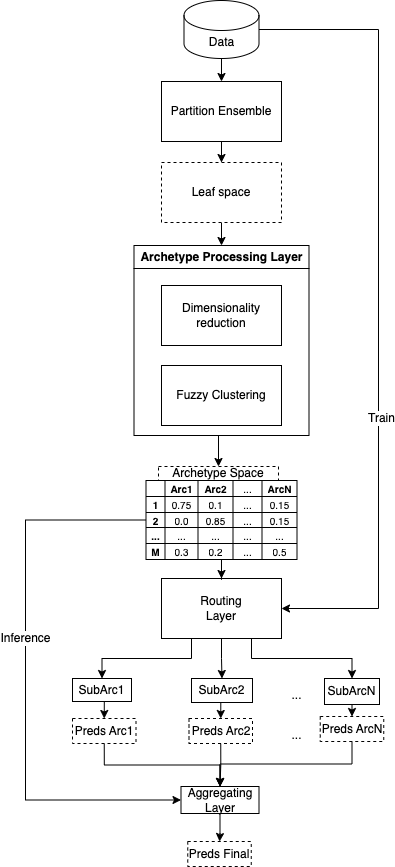

In [32]:
fancy_ensemble = ArchetypeEnsembleClassifier(
    base_embedder = ClusterArchetypeEncoder(
        regular_ensemble,
        clusterer = KMeans(10),
        embedder = GaussianRandomProjection(20)),
    final_transformer = regular_ensemble,
    transform_method = "transform",)


In [33]:
fancy_ensemble.fit(X_train, y_train)

/Users/alan.ganem/dev/personal/heterogeneous-metric-learning/hml/ensemble.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])


ArchetypeEnsembleClassifier(base_embedder=ClusterArchetypeEncoder(clusterer=KMeans(n_clusters=10),
                                                                  embedder=GaussianRandomProjection(n_components=20),
                                                                  ensemble_estimator=LGBMClassifier()),
                            final_transformer=LGBMClassifier())

In [34]:
test_df["fancy_pred"] = fancy_ensemble.predict_proba(X_test)[:,1]

# Validation

In [89]:
delta = 100*(roc_auc_score(test_df[TARGET], test_df["fancy_pred"]) - roc_auc_score(test_df[TARGET], test_df["naive_pred"]))

print(f"Delta AUC (0 to 100): {round(delta,3)}")

Delta AUC (0 to 100): 0.341


# ArchetypeEmbeddingClassifier with Logistic regression

In [416]:
linear_model = make_pipeline(QuantileTransformer(),LogisticRegression())
split_ensemble = RandomForestClassifier(n_jobs = -1)

In [424]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


cluster_sizes = [2,3,4,5,6,7,10,15,20,30,50]
aucs_test = []
aucs_train = []
for c in tqdm(cluster_sizes):
    np.random.seed(42)
    
    encoder = ClusterArchetypeEncoder(split_ensemble,
                            topn_archetypes = 3,
                            #alpha = 1,
                            clusterer = KMeans(c),
                            embedder = GaussianRandomProjection(10),
                           )
    
#     encoder = GraphArchetypeEncoder(split_ensemble,
#                             #topn_archetypes = c,
#                             #alpha = 1,
#                             n_archetypes=c,
#                             bipartite_adjacency = True,
#                            )
    
    
    # encoder = TargetArchetypeEncoder(regular_ensemble,
    #                         #topn_archetypes = 4,
    #                         #alpha = 1,
    #                         n_archetypes= c,
    #                        )
    
    estimator = ArchetypeEnsembleClassifier(
        base_embedder = encoder,
        final_transformer = linear_model,
        transform_method = "transform",)

    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:,1]
    preds_train = estimator.predict_proba(X_train)[:,1]
    aucs_test.append(roc_auc_score(y_test, preds))
    aucs_train.append(roc_auc_score(y_train, preds_train))
    

100%|███████████████████████████████████████████| 11/11 [00:28<00:00,  2.58s/it]


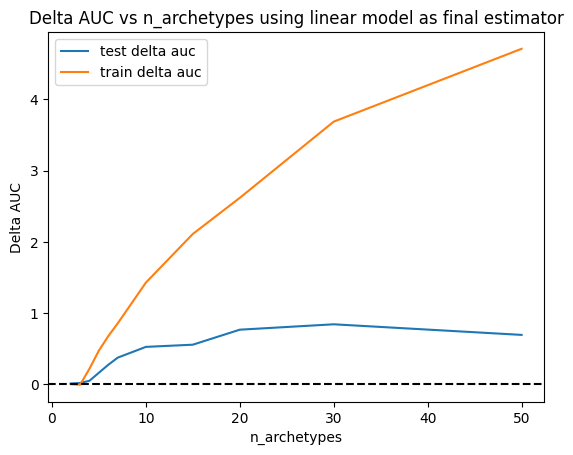

In [425]:
np.random.seed(42)
linear_model.fit(X_train, y_train)

baseline_auc_test = roc_auc_score(test_df[TARGET], linear_model.predict_proba(X_test)[:,1])
baseline_auc_train = roc_auc_score(train_df[TARGET], linear_model.predict_proba(X_train)[:,1])


plt.plot(cluster_sizes, [100*(a-baseline_auc_test) for a in aucs_test], label = "test delta auc")
plt.plot(cluster_sizes, [100*(a-baseline_auc_train) for a in aucs_train], label = "train delta auc")

plt.legend()
plt.title("Delta AUC vs n_archetypes using linear model as final estimator")
plt.xlabel("n_archetypes")
plt.ylabel("Delta AUC")
plt.axhline(0, ls = '--', color = "black")

# Hyperparams Sensititivty

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import QuantileTransformer
split_ensemble = LGBMClassifier(n_jobs = -1)
#split_ensemble = RandomForestClassifier(n_jobs = -1, min_samples_leaf=1)

regular_ensemble = LGBMClassifier(n_jobs = -1)
#regular_ensemble = make_pipeline(QuantileTransformer(), LogisticRegression(C = 0.01))
#regular_ensemble = RandomForestClassifier(n_jobs = -1, min_samples_leaf=1)

In [392]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


cluster_sizes = [2,3,4,5,6,7,10,15,20,30]
aucs_test = []
aucs_train = []
for c in tqdm(cluster_sizes):
    np.random.seed(42)
    
    encoder = ClusterArchetypeEncoder(split_ensemble,
                            #topn_archetypes = c,
                            #alpha = 1,
                            clusterer = KMeans(c),
                            embedder = GaussianRandomProjection(10),
                           )
    
#     encoder = GraphArchetypeEncoder(split_ensemble,
#                             #topn_archetypes = c,
#                             #alpha = 1,
#                             n_archetypes=c,
#                             bipartite_adjacency = True,
#                            )
    
    
    # encoder = TargetArchetypeEncoder(regular_ensemble,
    #                         #topn_archetypes = 4,
    #                         #alpha = 1,
    #                         n_archetypes= c,
    #                        )
    
    estimator = ArchetypeEnsembleClassifier(
        base_embedder = encoder,
        final_transformer = regular_ensemble,
        transform_method = "transform",)

    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:,1]
    preds_train = estimator.predict_proba(X_train)[:,1]
    aucs_test.append(roc_auc_score(y_test, preds))
    aucs_train.append(roc_auc_score(y_train, preds_train))
    

100%|███████████████████████████████████████████| 10/10 [00:43<00:00,  4.36s/it]


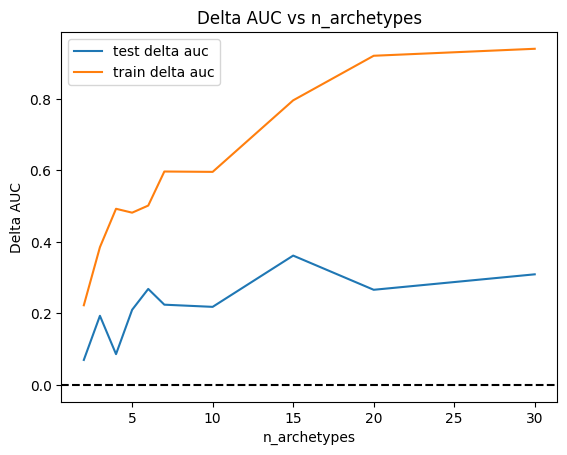

In [393]:
np.random.seed(42)
regular_ensemble.fit(X_train, y_train)

baseline_auc_test = roc_auc_score(test_df[TARGET], regular_ensemble.predict_proba(X_test)[:,1])
baseline_auc_train = roc_auc_score(train_df[TARGET], regular_ensemble.predict_proba(X_train)[:,1])


plt.plot(cluster_sizes, [100*(a-baseline_auc_test) for a in aucs_test], label = "test delta auc")
plt.plot(cluster_sizes, [100*(a-baseline_auc_train) for a in aucs_train], label = "train delta auc")

plt.legend()
plt.title("Delta AUC vs n_archetypes")
plt.xlabel("n_archetypes")
plt.ylabel("Delta AUC")
plt.axhline(0, ls = '--', color = "black")

In [382]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


alphas = [0, 0.25,0.5,0.75,1,1.25,1.5,2, 3]
aucs_test = []
aucs_train = []
for a in tqdm(alphas):
    np.random.seed(42)
    
    encoder = ClusterArchetypeEncoder(split_ensemble,
                            #topn_archetypes = c,
                            alpha = a,
                            clusterer = KMeans(10),
                            embedder = GaussianRandomProjection(10),
                           )
    
    estimator = ArchetypeEnsembleClassifier(
        base_embedder = encoder,
        final_transformer = regular_ensemble,
        transform_method = "transform",)

    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:,1]
    preds_train = estimator.predict_proba(X_train)[:,1]
    aucs_test.append(roc_auc_score(y_test, preds))
    aucs_train.append(roc_auc_score(y_train, preds_train))
    

100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.61s/it]


0.9053500663996572


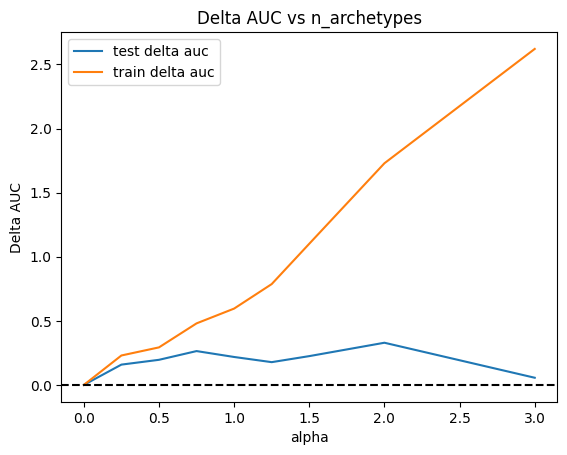

In [383]:
np.random.seed(42)
regular_ensemble.fit(X_train, y_train)

baseline_auc_test = roc_auc_score(test_df[TARGET], regular_ensemble.predict_proba(X_test)[:,1])
baseline_auc_train = roc_auc_score(train_df[TARGET], regular_ensemble.predict_proba(X_train)[:,1])

print(baseline_auc_test)

plt.plot(alphas, [100*(a-baseline_auc_test) for a in aucs_test], label = "test delta auc")
plt.plot(alphas, [100*(a-baseline_auc_train) for a in aucs_train], label = "train delta auc")

plt.legend()
plt.title("Delta AUC vs n_archetypes")
plt.xlabel("alpha")
plt.ylabel("Delta AUC")
plt.axhline(0, ls = '--', color = "black")

In [384]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


emb_dim_sizes = [2,5,10,20,50,100,200]
aucs_test = []
aucs_train = []
for d in tqdm(emb_dim_sizes):
    np.random.seed(42)
    
    encoder = ClusterArchetypeEncoder(split_ensemble,
                            #topn_archetypes = c,
                            #alpha = 1,
                            clusterer = KMeans(10),
                            embedder = GaussianRandomProjection(d),
                           )
    
    # encoder = GraphArchetypeEncoder(split_ensemble,
    #                         #topn_archetypes = c,
    #                         #alpha = 1,
    #                         n_archetypes=c,
    #                         bipartite_adjacency = True,
    #                        )
    
    
    # encoder = TargetArchetypeEncoder(regular_ensemble,
    #                         #topn_archetypes = 4,
    #                         #alpha = 1,
    #                         n_archetypes= c,
    #                        )
    
    estimator = ArchetypeEnsembleClassifier(
        base_embedder = encoder,
        final_transformer = regular_ensemble,
        transform_method = "transform",)

    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:,1]
    preds_train = estimator.predict_proba(X_train)[:,1]
    aucs_test.append(roc_auc_score(y_test, preds))
    aucs_train.append(roc_auc_score(y_train, preds_train))
    

100%|█████████████████████████████████████████████| 7/7 [00:26<00:00,  3.74s/it]


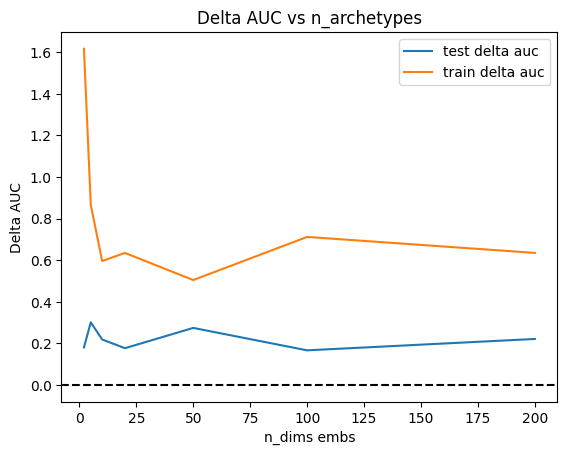

In [385]:
np.random.seed(42)

regular_ensemble.fit(X_train, y_train)

baseline_auc_test = roc_auc_score(test_df[TARGET], regular_ensemble.predict_proba(X_test)[:,1])
baseline_auc_train = roc_auc_score(train_df[TARGET], regular_ensemble.predict_proba(X_train)[:,1])

plt.plot(emb_dim_sizes, [100*(a-baseline_auc_test) for a in aucs_test], label = "test delta auc")
plt.plot(emb_dim_sizes, [100*(a-baseline_auc_train) for a in aucs_train], label = "train delta auc")

plt.legend()
plt.title("Delta AUC vs n_archetypes")
plt.xlabel("n_dims embs")
plt.ylabel("Delta AUC")
plt.axhline(0, ls = '--', color = "black")

# Comparison to Bagging

### Bagging

In [390]:
from tqdm import tqdm
import warnings
from sklearn.ensemble import BaggingClassifier
warnings.filterwarnings("ignore")


cluster_sizes = [2,3,4,5,6,7,10,15,20,30,50,100]
aucs_test = []
aucs_train = []
for c in tqdm(cluster_sizes):
    np.random.seed(42)
    
#     encoder = ClusterArchetypeEncoder(split_ensemble,
#                             #topn_archetypes = c,
#                             #alpha = 1,
#                             clusterer = KMeans(c),
#                             embedder = GaussianRandomProjection(10),
#                            )
    
#     encoder = GraphArchetypeEncoder(split_ensemble,
#                             #topn_archetypes = c,
#                             #alpha = 1,
#                             n_archetypes=c,
#                             bipartite_adjacency = True,
#                            )
    
    
    # encoder = TargetArchetypeEncoder(regular_ensemble,
    #                         #topn_archetypes = 4,
    #                         #alpha = 1,
    #                         n_archetypes= c,
    #                        )
    
    estimator = BaggingClassifier(regular_ensemble, n_estimators = c, bootstrap = True, )

    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:,1]
    preds_train = estimator.predict_proba(X_train)[:,1]
    aucs_test.append(roc_auc_score(y_test, preds))
    aucs_train.append(roc_auc_score(y_train, preds_train))
    

100%|███████████████████████████████████████████| 12/12 [00:43<00:00,  3.65s/it]


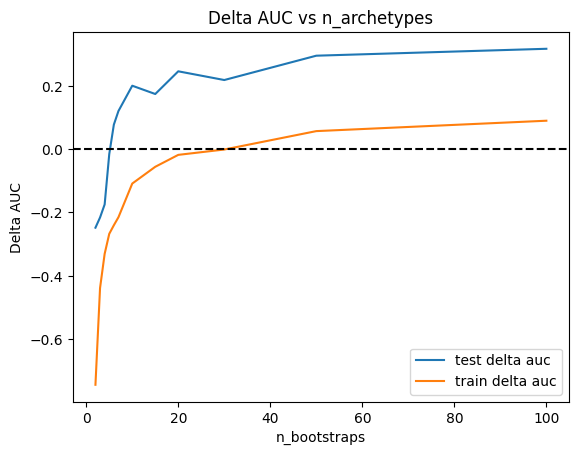

In [391]:
np.random.seed(42)
regular_ensemble.fit(X_train, y_train)

baseline_auc_test = roc_auc_score(test_df[TARGET], regular_ensemble.predict_proba(X_test)[:,1])
baseline_auc_train = roc_auc_score(train_df[TARGET], regular_ensemble.predict_proba(X_train)[:,1])


plt.plot(cluster_sizes, [100*(a-baseline_auc_test) for a in aucs_test], label = "test delta auc")
plt.plot(cluster_sizes, [100*(a-baseline_auc_train) for a in aucs_train], label = "train delta auc")

plt.legend()
plt.title("Delta AUC vs n_archetypes")
plt.xlabel("n_bootstraps")
plt.ylabel("Delta AUC")
plt.axhline(0, ls = '--', color = "black")

### Bagging + Archeytpe Ensembling

In [388]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


cluster_sizes = [2,3,4,5,6,7,10,15,20]
aucs_test = []
aucs_train = []
for c in tqdm(cluster_sizes):
    np.random.seed(42)
    
    encoder = ClusterArchetypeEncoder(split_ensemble,
                            #topn_archetypes = c,
                            #alpha = 1,
                            clusterer = KMeans(c),
                            embedder = GaussianRandomProjection(10),
                           )
    
#     encoder = GraphArchetypeEncoder(split_ensemble,
#                             #topn_archetypes = c,
#                             #alpha = 1,
#                             n_archetypes=c,
#                             bipartite_adjacency = True,
#                            )
    
    
    # encoder = TargetArchetypeEncoder(regular_ensemble,
    #                         #topn_archetypes = 4,
    #                         #alpha = 1,
    #                         n_archetypes= c,
    #                        )
    
    estimator = ArchetypeEnsembleClassifier(
        base_embedder = encoder,
        final_transformer = BaggingClassifier(regular_ensemble, n_estimators = 10, bootstrap = True, ),
        transform_method = "transform",)

    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:,1]
    preds_train = estimator.predict_proba(X_train)[:,1]
    aucs_test.append(roc_auc_score(y_test, preds))
    aucs_train.append(roc_auc_score(y_train, preds_train))
    

100%|█████████████████████████████████████████████| 9/9 [03:24<00:00, 22.75s/it]


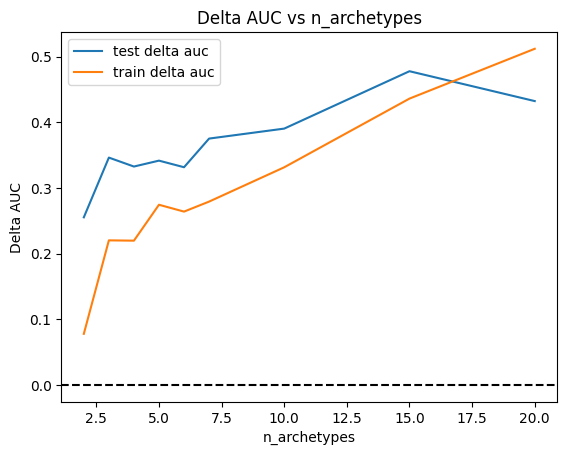

In [389]:
np.random.seed(42)
regular_ensemble.fit(X_train, y_train)

baseline_auc_test = roc_auc_score(test_df[TARGET], regular_ensemble.predict_proba(X_test)[:,1])
baseline_auc_train = roc_auc_score(train_df[TARGET], regular_ensemble.predict_proba(X_train)[:,1])


plt.plot(cluster_sizes, [100*(a-baseline_auc_test) for a in aucs_test], label = "test delta auc")
plt.plot(cluster_sizes, [100*(a-baseline_auc_train) for a in aucs_train], label = "train delta auc")

plt.legend()
plt.title("Delta AUC vs n_archetypes")
plt.xlabel("n_archetypes")
plt.ylabel("Delta AUC")
plt.axhline(0, ls = '--', color = "black")

In [ ]:
# TODO, implement baesyan bootstrap on ArchetypeEnsembleClassifier 